In [1]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Step 1: Load Data
data = pd.read_csv('studentset.csv', on_bad_lines='warn', delimiter=';')
print(data.head())

                                    transcript,label
0  So when I was a kid ... this was my team.(Laug...
1  This is how war starts. One day you're living ...
2  In the next 18 minutes, I'm going to take you ...
3  Before March, 2011, I was a photographic retou...
4  Chris Anderson: And now we go live to Caracas ...


In [3]:
# Step 2: Data Preprocessing
data = data.rename(columns=lambda x: x.strip().lower())
if 'transcript,label' in data.columns:
    split_columns = data['transcript,label'].str.split(',', n=1, expand=True)
    if split_columns.shape[1] == 2:
        data[['transcript', 'label']] = split_columns
    data.drop(columns=['transcript,label'], inplace=True)

if 'transcript' in data.columns and 'label' in data.columns:
    data.dropna(subset=['transcript', 'label'], inplace=True)

data['label'] = data['label'].apply(lambda x: 'positive' if 'positive' in x.lower() else 'negative')

label_counts = data['label'].value_counts()
print(label_counts)

if len(label_counts) <= 1 or min(label_counts) == 0:
    raise ValueError(f"The target 'y' still needs to have more than 1 class after balancing. Got {len(label_counts)} class instead, with counts: {label_counts}.")

X = data['transcript']
y = data['label']

label
negative    1605
positive     245
Name: count, dtype: int64


In [4]:
# Stap 3: Labels omzetten naar numerieke waarden
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [5]:
# Stap 4: Oversampling om dataset te balanceren
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)
X_resampled = X_resampled.flatten()

In [6]:
# Stap 5: Gebruik StratifiedShuffleSplit om de dataset te splitsen
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

In [7]:
# Stap 6: Tekst omzetten naar numerieke representatie met TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [8]:
# Stap 7: Model Training
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [9]:
# Stap 8: Model Evaluatie
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.77       321
           1       0.73      0.98      0.84       321

    accuracy                           0.81       642
   macro avg       0.85      0.81      0.81       642
weighted avg       0.85      0.81      0.81       642


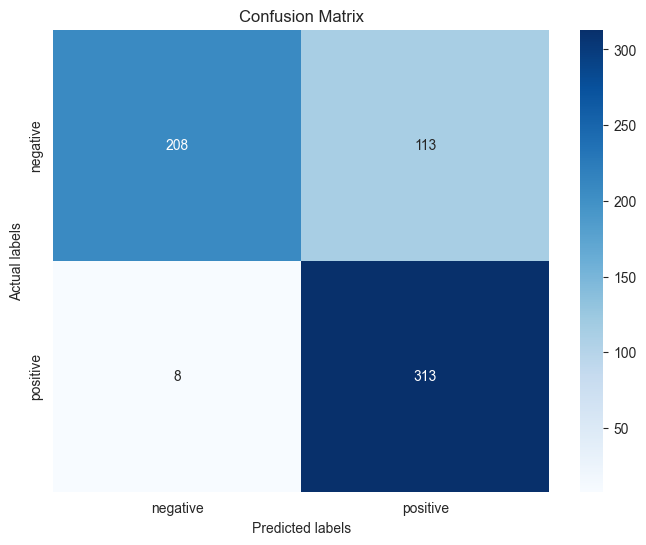

In [10]:
# Stap 9: Confusiematrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Voorspelde labels')
plt.ylabel('Werkelijke labels')
plt.title('Confusiematrix')
plt.show()

In [11]:
# Stap 10: Nieuwe voorspelling
new_text = ["Dit is een fantastische ervaring"]
new_text_tfidf = vectorizer.transform(new_text)
new_prediction = model.predict(new_text_tfidf)
print("Voorspelling voor nieuwe tekst:", label_encoder.inverse_transform(new_prediction))

joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


Prediction for new text: ['positive']


['tfidf_vectorizer.pkl']